# Definición del problema a resolver
• ¿Cuál es el problema?

• Acción que buscamos hacer para solucionar el problema

• ¿Cuáles son las variables disponibles?

• ¿En qué momento se va a implantar el modelo? ¿Qué variables hay disponibles en
el momento de llamada al modelo?

• ¿Cómo se va a validar el modelo?


Aquí hay que redactar una introducción explicando el caso y toda la parafernalia...

# Exploración general / inicial
• Dimensiones de la tabla y variables

• Analizar si las variables estarán disponibles en el momento de la llamada al modelo
(sino se estaría introduciendo información a futuro en el modelo)

• Exploración de la variable objetivo

• Rápido análisis de valores nulos

• Se explora el número de variables numéricas y categóricas y se decide qué proceso
realizar para tratarlas

• Transformaciones iniciales de algunas variables: formato de fechas, eliminar
espacios de una variable string, etc

• Analizar la variable objetivo: aislándola de las demás variables (quizás, a pesar de
no tener en cuenta las variables tenemos que sacar un 80% de accuracy.

In [1]:
#Librerías
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import plotly.express as px

In [2]:
#Importamos los datos
df = pd.read_csv("../data/NCDB_1999_to_2014.csv")

C:\Users\atell\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print("El dataset está compuesto por", len(df.index), "filas y", len(df.columns), "columnas")
df.head(5)

El dataset está compuesto por 5860405 filas y 22 columnas


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [4]:
# Cambio de nombre de las variables
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

print(len(new_names) == len(df.columns))

df.columns = new_names

True


In [5]:
# Comprobamos el tipo de las variables, la mayoría son categóricas
df.dtypes 

year                   int64
month                 object
weekday               object
hour                  object
fatality               int64
vehicles_involved     object
crash_type            object
crash_place           object
crash_weather         object
surface_state         object
road_slope            object
traffic_state         object
vehicle_id            object
vehicle_type          object
vehicle_year          object
passenger_id          object
passenger_sex         object
passenger_age         object
passenger_role        object
passenger_fatality    object
passenger_safety      object
passenger_type        object
dtype: object

In [6]:
# Cambio de la variable vehicle_year a años de antigüedad (la he metido en otra columna por el momento)
df['vehicle_age'] = df.year - pd.to_numeric(df.vehicle_year, errors= "coerce")

# Variables futuras y duplicados

El dataset contiene variables que no están disponible en el momento de la colisión y por tanto escapan al objetivo de nuestro ánalisis y otras que directamente no son de útilidad como IDs. También debemos prescindir de registros duplicados antes de eliminar los IDs

In [7]:
print(df.shape)
df = df.drop_duplicates().drop(["passenger_id","passenger_fatality", "vehicle_id"], axis=1)
df.shape

(5860405, 23)


(5855336, 20)

# Variable Objetivo

In [8]:
# Recodeado de la variable objetivo
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 0-no fatality
df['fatality'] = df['fatality'].replace({2:0})

In [9]:
# Plot variable target. Podemos ver que el dataset está muy desbalanceado
fatality_per = df['fatality'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fatality_count = df['fatality'].value_counts().reset_index()
fataity_merge= pd.merge(fatality_per, fatality_count, on=['index'], how='inner')
fig = px.histogram(fataity_merge, x="index", y=['percent'], labels={'index':'fatality'})
fig.show()

# Valores Nulos

En el diccionario de datos encontramos varios tipos de datos ausentes. Principalmente U, UU y UUUU que son datos estirctamente desconocidos. Luego tenemos los X, XX y XXXX que son no proporcionados por la jurisdicción, no encontramos ningun registro con esta etiqueta en los datos. Por otro lado tenemos los N, NN y NNNN que hacen referncia a que la variable no aplica a el registro concreto estos no son nulos y deben ser tratados como otra categoría. Por último los Q, QQ, QQQQ que son otras opciones que no aparecen en las posibles y tampoco deben ser tratados como nulos.

In [10]:
# Remplazamos U, UU y UUUU por NAs
df = df.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [16]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
19,passenger_safety,607889,object,0.103958
18,vehicle_age,577389,float64,0.098742
17,crash_place,500643,object,0.085617
16,road_slope,428671,object,0.073309
15,passenger_age,369398,object,0.063172
14,vehicle_year,317683,object,0.054328
13,passenger_sex,228239,object,0.039032
12,traffic_state,219386,object,0.037518
11,crash_type,176698,object,0.030218
10,passenger_type,169748,object,0.029029


In [13]:
null_rows = df.isnull().sum(axis=1).sort_values(ascending=False)
nulos_filas = pd.DataFrame(null_rows, columns=['nulos_filas'])  
nulos_filas['target'] = df['fatality'].copy()
nulos_filas['porcentaje_filas']= nulos_filas['nulos_filas']/df.shape[1]
nulos_filas

,nulos_filas,target,porcentaje_filas
5245711,17,1,0.85
5245712,17,1,0.85
2884064,14,0,0.70
769190,14,0,0.70
1244965,13,0,0.65
...,...,...,...
2768892,0,0,0.00
2768895,0,0,0.00
2768896,0,0,0.00
2768897,0,0,0.00


In [14]:
# Podemos ver como la mayoría de filas con mas de 40% NAs no son fatalities
# En una proporción bastante menor a la que encontramos en el conjunto de datos
NA_0 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==0)].count()
NA_1 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==1)].count()
print(NA_0, NA_1)
NA_1/NA_0

7840 45


0.005739795918367347

Tras hacer el analisis de los nulos por filas y por columnas. Procedemos a eliminar los registros con más nulos. En cuanto a columnas mantenemos todas puesto que solo una de ellas supera ligeramente el 10% de nulos una cantidad dentro de un treshold razonable y puede ser una variable de interés para el modelo. En cuanto a las filas vamos a eliminar todos los registros que contengan más de un 40% de nulos, es decir, 8 o más variables con valor nulo en un solo registro.

In [15]:
#Eliminando los registros con >40% nulos
nulos_40 = list(nulos_filas.index[nulos_filas.porcentaje_filas>=0.40])
df = df.loc[set(df.index)-set(nulos_40)]

In [26]:
#TODO: ¿Que hacemos con dummies NN?
df[df.passenger_age=='NN']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
5860380     01
5860401     05
5860402     01
5860403     01
5860404     01
Name: crash_place, Length: 5847451, dtype: object

# En progreso (ignorar)

In [ ]:
# Columna MONTH
print(df["month"].unique())
df["month"] = np.int8(df["month"].replace({"01": 1, "02": 2, "11": 11, "12" : 12}))
df = df[df["month"] != 0]
df["month"].unique()
month_analysis = df.groupby(["month", "fatality"]).size()

for i in range(1, 1+ np.int8(len(month_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el mes",
    i ,"es del",round(month_analysis[i][1]/month_analysis[i].sum()*100, 3), "%")
month_analysis[2]
### Dividiremos la variable month en cuatro valores distintos, representando los distintos trimestres del año (Q1-4).
#### La razón para esto es la existencia de un patrón estacional en el que los distintos trimestres (o estaciones del año) tienen valores similares a la hora de relacionarse con la variable objetivo $fatality$
# df["month"] = df["month"].replace({1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4})
## Columna Weekday
print(df["weekday"].unique())
df["weekday"] = np.int8(df["weekday"].replace({"7": 7, "1": 1, "2": 2, "3" : 3, "4":4, "5":5, "6":6}))
print(df["weekday"].unique())
#Las filas con NA en weekday (valor 0 para el día de la semana) son un número mínimo en comparación con el tamaño del data-set así que nos deshacemos de ellas
# Nos deshacemos de esas filas
df = df[df["weekday"] != 0]
weekday_analysis = df.groupby(["weekday", "fatality"]).size()

for i in range(1, 1+ np.int8(len(weekday_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el día de la semana",
    i ,"es del",round(weekday_analysis[i][1]/weekday_analysis[i].sum()*100, 3), "%")
## Columna $hour$
### Opción 1: https://towardsdatascience.com/how-to-handle-cyclical-data-in-machine-learning-3e0336f7f97c
### Opción 2: Identificar distintos "tramos" de similar influencia en $fatalities$ y luego hotencodearlo. Habría que hacerlo por tramos para reducir, ya que 24 variables para la hora quizás sean demasiadas
df = df[df["hour"].notnull()]
df["hour"] = df["hour"].astype("int8")
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,6), dpi=80)


hour_analysis = df.groupby(["hour", "fatality"]).size()
hour_values = list()

for i in range(0, int(len(hour_analysis)/2)):
    print("El porcentaje de fatalities/accidente para la hora",
    i ,"es del",round(hour_analysis[i][1]/hour_analysis[i].sum()*100, 3), "%")
    hour_values.append(hour_analysis[i][1]/hour_analysis[i].sum()*100)

hour_values = pd.DataFrame(hour_values)
hour_values.T.iloc[0].plot()

# He pensado en unificar las columnas de fecha pero he observado que la proporción de muertes / heridos es bastante diferente según el día de la semana (e imagino que también por la hora)

print(df.fatality.value_counts() / len(df.index) * 100)

df.loc[df["weekday"] == 6].fatality.value_counts() / len(df.loc[df["weekday"] == 6].index) * 100


# 1. Colisiones y Tiempo

### 1.1. Observación del periodo completo

In [8]:
df["date"] = pd.DatetimeIndex(df["year"].map(str) + "-" + df["month"].map(str))
df["fatal"] = np.where(df["fatality"]==1, 1, 0)
df["non_fatal"] = np.where(df["fatality"]==0, 1, 0)

<ipython-input-9-0ea25cf3c62c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  time_collision_both = df.groupby('date')["fatal","non_fatal"].sum()


Text(0, 0.5, 'Number of deadly colissions')

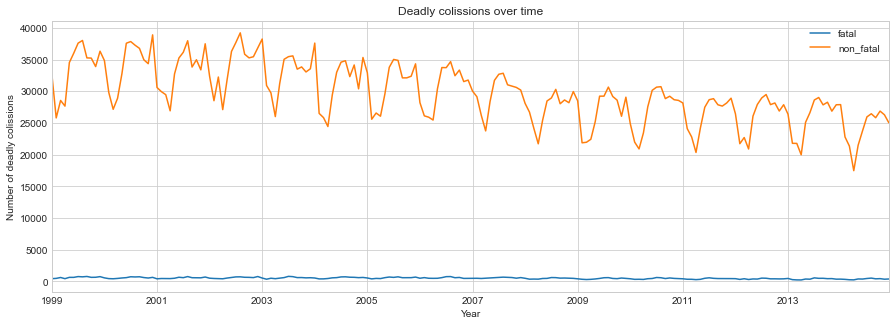

In [9]:
time_collision_both = df.groupby('date')["fatal","non_fatal"].sum()
plot = time_collision_both.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

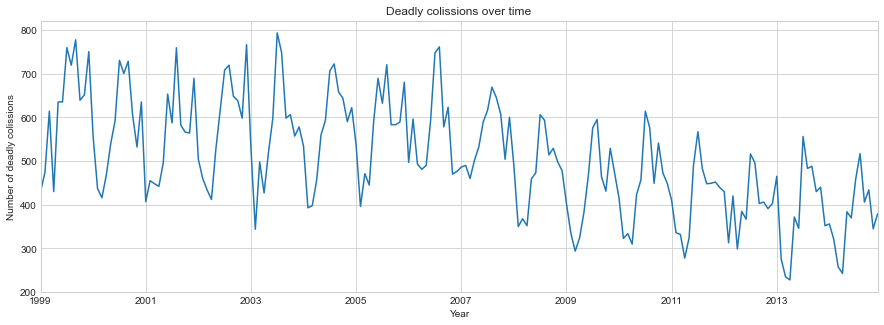

In [10]:
time_collision_fatal = df.groupby('date')["fatal"].sum()
plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

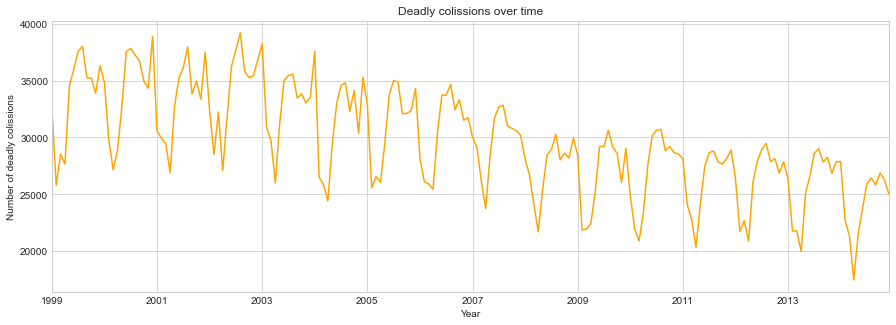

In [11]:
time_collision_nonfatal = df.groupby('date')["non_fatal"].sum()
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color = "orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

### 1.2. Observación reducida a los últimos 5 años

Text(0, 0.5, 'Number of deadly colissions')

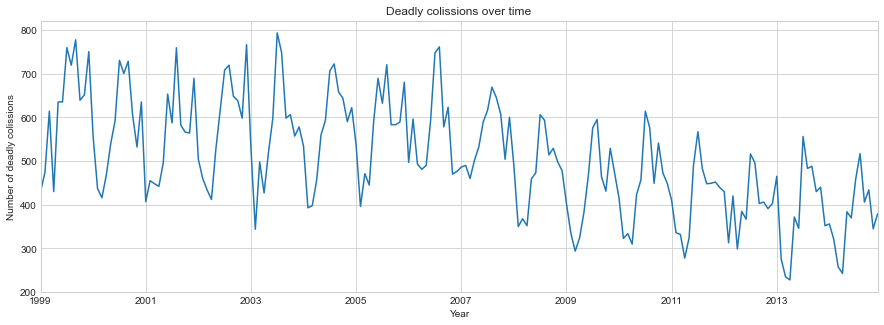

In [12]:
df_reduced = df.loc[df["date"] >= "2009"]

plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

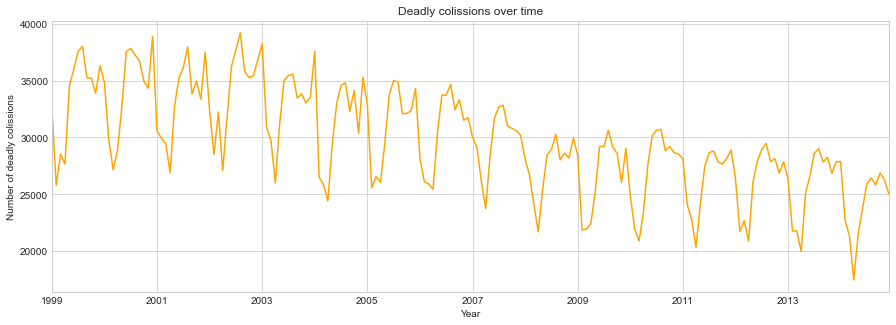

In [13]:
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color="orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

### 1.3 Correlación entre los valores de la variable objetivo

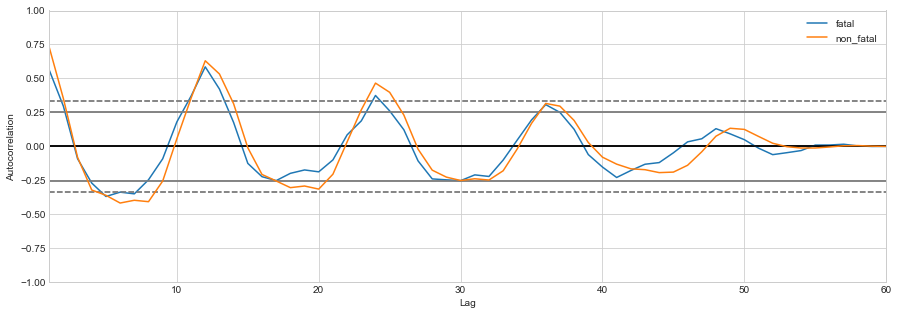

In [14]:
plt.figure(figsize=(15,5))
for c in time_collision_both.columns:
    autocorrelation_plot(time_collision_both[c][-60:],label=c);

C:\Users\atell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


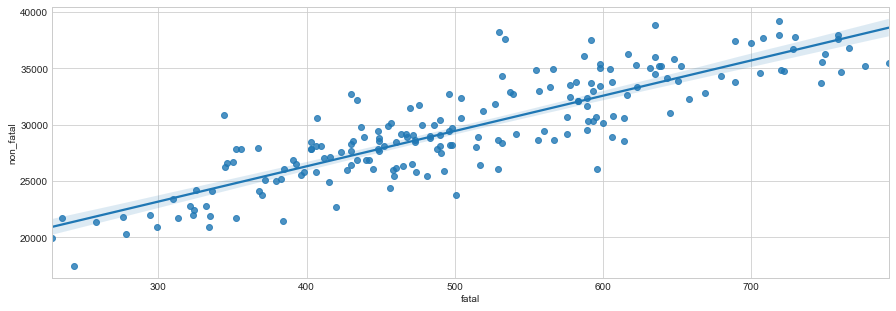

In [15]:
plt.figure(figsize=(15,5))
sns.regplot('fatal', 'non_fatal', data=time_collision_both);

In [16]:
corr = time_collision_both.corr()
print("La correlación entre los accidentes fatales y no fatales es de", str(round(corr["fatal"]["non_fatal"], 3)))
corr

La correlación entre los accidentes fatales y no fatales es de 0.861


,fatal,non_fatal
fatal,1.000000,0.861117
non_fatal,0.861117,1.000000


# 2. Análisis de los días de la semana y las horas

### 2.1. Días de la semana

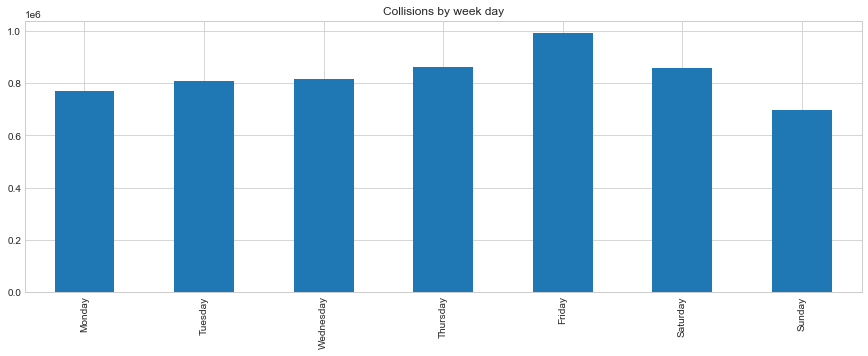

In [17]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_analysis = df.groupby("weekday")["fatality"].count()
weekday_analysis.index = index
plt.figure(figsize=(15,5))
plot = weekday_analysis.plot(kind="bar", title = "Collisions by week day")

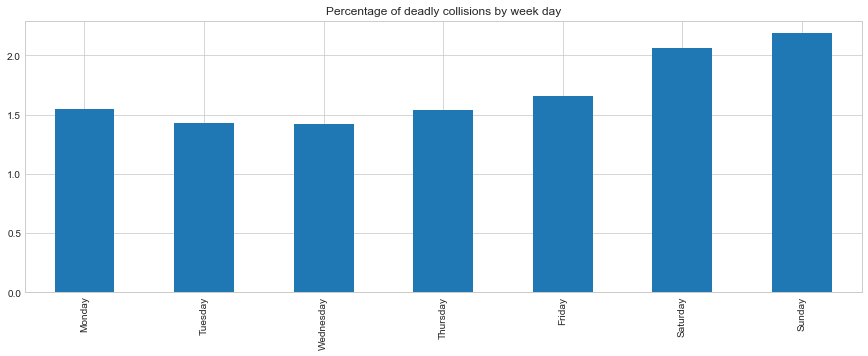

In [18]:
weekday_analysis = df.groupby(["weekday", "fatality"]).size()
serie_weekday = list()
for i in range(1, 8):
    serie_weekday.append(weekday_analysis[i][1] / weekday_analysis[i].sum() * 100)

weekday_analysis_serie = pd.Series(serie_weekday, index = index)
plt.figure(figsize=(15,5))
plot = weekday_analysis_serie.plot(kind="bar", title = "Percentage of deadly collisions by week day")

### 2.2. Horas del día

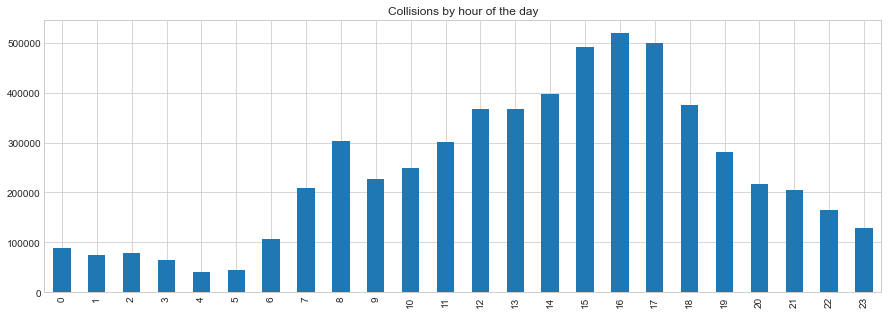

In [19]:
index = np.arange(0,24)
hour_analysis = df.groupby("hour")["fatality"].count()
hour_analysis.index = index
plt.figure(figsize=(15,5))
plot = hour_analysis.plot(kind="bar", title = "Collisions by hour of the day")

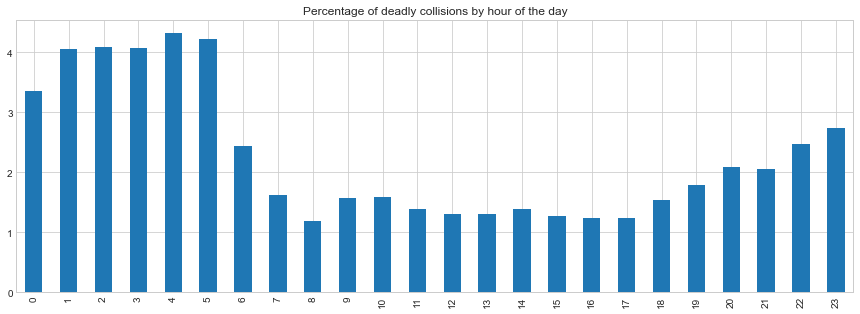

In [20]:
hour_analysis = df.groupby(["hour", "fatality"]).size()
serie_weekday = list()
for i in range(0, 24):
    serie_weekday.append(hour_analysis[i][1] / hour_analysis[i].sum() * 100)

hour_analysis = pd.Series(serie_weekday, index = index)
plt.figure(figsize=(15,5))
plot = hour_analysis.plot(kind="bar", title = "Percentage of deadly collisions by hour of the day")

# 3. Colisiones y Carretera

### 3.1. Road Configuration

In [31]:
place_analysis

crash_place
01    2076701
02    2741474
03     288687
04      23705
05      51137
06       5998
07       1008
08      11759
09       1741
10        556
QQ     144042
Name: fatality, dtype: int64

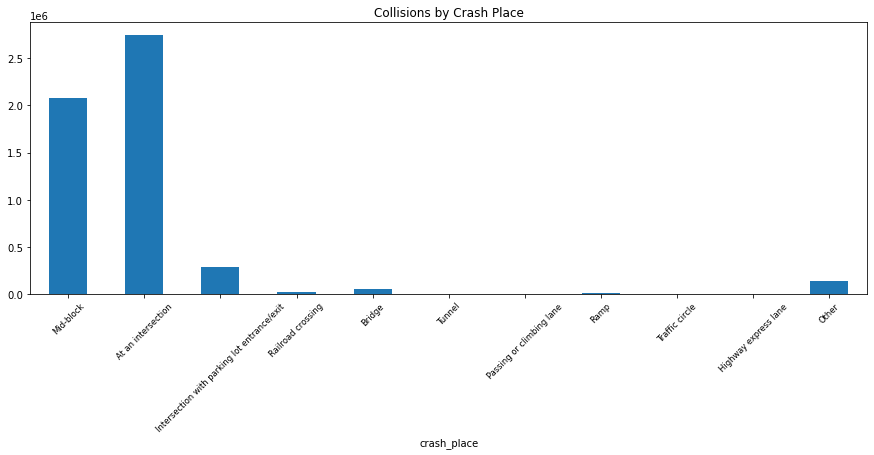

In [40]:
index = np.arange(1,12)
place_analysis = df.groupby("crash_place")["fatality"].count()
# place_analysis.index = index
plt.figure(figsize=(15,5))
plot = place_analysis.plot(kind="bar", title = "Collisions by Crash Place")
place_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane', 'Other']

plt.xticks(np.arange(0,11),place_type,rotation=45, size='small' ); 

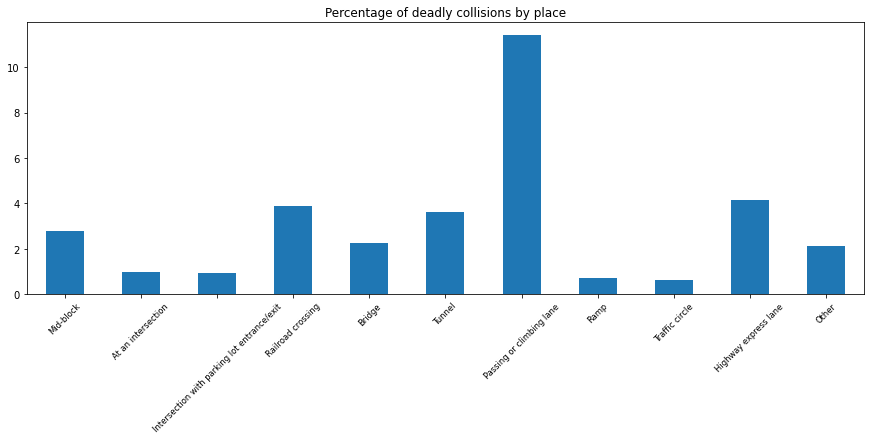

In [43]:
place_analysis = df.groupby(["crash_place", "fatality"]).size()
serie_place = list()

for i in range(0, 11):
    serie_place.append(place_analysis[:,1][i] / (place_analysis[:,1][i] +(place_analysis[:,0][i])) * 100)

place_analysis = pd.Series(serie_place, index = range(0,11))
plt.figure(figsize=(15,5))
plot = place_analysis.plot(kind="bar", title = "Percentage of deadly collisions by place")
plt.xticks(np.arange(0,11),place_type,rotation=45, size='small' ); 

# 4 Condiciones Climáticas